In [1]:

%pylab inline

import tensorflow as tf
%matplotlib inline
import numpy as np
from collections import deque
from os import listdir
import functools


import pylab
from tsne import bh_sne
from matplotlib import pyplot as plt
import pandas
import scipy
import numpy as np
import sklearn.manifold
import os
import gc
from time import gmtime, strftime
import seaborn as sns
from os import listdir
from os.path import isfile, join
import math
from scipy.stats.stats import pearsonr
import random as rand
import pyproj
import functools
import pickle
import random


image_width = 128

def display(image, min = 0.0, max = 1.0):
    plt.imshow(image, cmap = plt.get_cmap('gray'), interpolation='nearest')
    plt.show()
    




def display(image):
    plt.imshow(image, cmap = plt.get_cmap('gray'), interpolation='nearest')
    plt.show()
    
def memoize(obj, maxlen = 2000):
    """A decorator to cache advice objects using the advice key"""
    cache = obj.cache = {}
    deck = obj.deck = deque([], maxlen = maxlen)

    @functools.wraps(obj)
    def memoizer(*args, **kwargs):
        key = args[0]
        if key not in cache:
            if len(deck) == deck.maxlen:
              del cache[deck.popleft()[0]]
            temp = obj(*args, **kwargs)
            cache[key] = temp
            deck.append((key, temp))
        return cache[key]
        
    return memoizer

@memoize
def load_mat_from_file(key):
    f = file("/home/isaac/Desktop/devika/ARCGIS/ArcGis/pickle_files/"+key+".npy","rb")
    return np.load(f)

@memoize
def get_file_containing(housex, housey):
#         print "house coords:", housex, housey
    for key in file_attributes:
        block = file_attributes[key]
    #         print block['xllcorner'], block['yllcorner']
        if block['xllcorner'] < housex < block['xllcorner'] + block['width']:
            if block['yllcorner'] < housey < block['yllcorner'] + block['height']:
                return key
    assert(1==0)

def imagex(housex, housey, block):
    return (int(housex)-block['xllcorner'])/5
def imagey(housex, housey, block):
    return (int(housey)-block['yllcorner'])/5



#housex and housey in meters
def get_heightmap_around(housex, housey, window_width_pixels = 28):
    
    def image_slice(key, housex, housey, radius = window_width_pixels/2):
        x = housex
        y = housey
        block = file_attributes[key]
        mat = load_mat_from_file(key)
        x1 = np.max([0,              imagex(x,y,block) - radius])
        x2 = np.min([block['ncols'], imagex(x,y,block) + radius])
        
        y1 = np.max([0,              imagey(x,y,block) - radius])
        y2 = np.min([block['nrows'], imagey(x,y,block) + radius])
        
        assert(x1 <= x2)
        assert(y1 <= y2)
        return  mat[block['nrows'] - y2:block['nrows'] - y1, x1:x2]
    
    window_width_feet = window_width_pixels * 5
    housex /= .3048 #convert to feet
    housey /= .3048
    x = housex
    y = housey
    ul = get_file_containing(x - window_width_feet/2, y - window_width_feet/2)
    ur = get_file_containing(x + window_width_feet/2, y - window_width_feet/2)
    ll = get_file_containing(x - window_width_feet/2, y + window_width_feet/2)
    lr = get_file_containing(x + window_width_feet/2, y + window_width_feet/2)

    for key in [ul, ur, ll, lr]:
        image = image_slice(key, x, y)
#         print image.shape
        if image.shape == (window_width_pixels, window_width_pixels):
            return image

    

    if ul == ur and lr == ll : # horizontal split


        result = np.zeros([window_width_pixels, window_width_pixels])
        upper_slice = image_slice(ul, housex, housey)
        lower_slice = image_slice(ll, housex, housey)
        
        result[:upper_slice.shape[0], :] = upper_slice
        result[ window_width_pixels - lower_slice.shape[0]:, :] = lower_slice


        return result
    elif ul == ll and ur == lr and ul != ur and ll != lr: # vertical split
        result = np.zeros([window_width_pixels, window_width_pixels])
        left_slice = image_slice(ll, housex, housey)
        right_slice = image_slice(ur, housex, housey)
#         print left_slice.shape
#         print right_slice.shape
        
        result[:, :left_slice.shape[1]] = left_slice
        result[:, window_width_pixels - right_slice.shape[1]:] = right_slice

#         plt.imshow(result)
#         plt.show()
#         display(result)

        return result
    else: # four way split
#         print "four way"
        ll_slice = image_slice(ll, housex, housey)
        ul_slice = image_slice(ul, housex, housey)
        lr_slice = image_slice(lr, housex, housey)
        ur_slice = image_slice(ur, housex, housey)
        
        result = np.zeros([window_width_pixels, window_width_pixels])
        result[:ll_slice.shape[0], :ll_slice.shape[1]] = ll_slice
        result[:lr_slice.shape[0], window_width_pixels - lr_slice.shape[1]:] = lr_slice
        
        result[window_width_pixels - ul_slice.shape[0]:, :ul_slice.shape[1]] = ul_slice
        result[window_width_pixels - ur_slice.shape[0]:, window_width_pixels - ur_slice.shape[1]:] = ur_slice
#         display(result)
        return result

        

def window_violated_chunk_borders(housex, housey):
    corners = [(housex-window_width_feet/2, housey-window_width_feet/2),
              (housex-window_width_feet/2, housey+window_width_feet/2),
              (housex+window_width_feet/2, housey+window_width_feet/2),
              (housex+window_width_feet/2, housey-window_width_feet/2)]
    files = map(lambda x: get_file_containing(x[0], x[1]), corners)
    return len(set(files)) > 1



file_attributes = {}

mypath = "/home/isaac/Desktop/devika/ARCGIS/ArcGis/ascii_files"
for filename in [f for f in listdir(mypath) if isfile(join(mypath, f))]: 
    attributes = {}
    with open(mypath + "/" + filename) as FileObj:
        for index, line in enumerate(FileObj):
            if(index < 6):
#                 print line
                attributes[line.split(" ")[0]] = int(line.split(" ")[-1][:-2])
            else:
                break # don't load the other lines into memory becuase that's a waste of time.

    attributes['width'] = attributes['ncols'] * attributes['cellsize']
    attributes['height'] = attributes['nrows'] * attributes['cellsize']
    file_attributes[filename] = attributes
print "loaded all file header attributes into dict"


def load_data(path, normalize_columns = False, only_columns_containing = ""):
    print("loading...")
    gc.collect() # collect garbage
    data = pandas.read_hdf(path, '/df')
    df = pandas.DataFrame(data)
    df = df.sort(['hcad']).fillna(0)
    df = df.reset_index()#(ascending=True)

    data_dict = {}
    for label in set(df._get_numeric_data().columns).union({'hcad'}):
        # union hcad to ensure that hcad col comes in even if not considered numerical
        if normalize_columns and  label != 'hcad':
            column_data = np.array(df[label].astype(float))
            column_data -= np.min(column_data)
            data_dict[label] = column_data / np.max(column_data)
        elif label != 'hcad':
            data_dict[label] = df[label].astype(float)

    result = pandas.DataFrame.from_dict(data_dict)

    result = result.replace([np.inf, -np.inf], 1)
    
    
    for label in result:
        if not only_columns_containing in str(label):
            result.drop([str(label)], axis = 1 , inplace= True)

    return result


wind_data = load_data("/home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad100_hist8x8.mat.hd", 
              normalize_columns=True, only_columns_containing = "spd")
meta = load_data("/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd")
y_data = load_data("/home/isaac/Dropbox/data_for_brian/y_df.hd")
hcad = load_data("/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_point.hd", 
              normalize_columns=True)
# wind_data = wind_data[meta['img0'] == 1]
# y_data = wind_data[meta['img0'] == 1]
y_gaussian = pickle.load(open( "/home/isaac/Desktop/house_guassian_damage_balance.p", "rb" ) )

wgs84=pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth
UTM26N=pyproj.Proj("+init=EPSG:2278") # UTM coords, zone Texas Central, WGS84 datum



# metamat, extra_features, regression_y, cat_y = get_batch(1, random = False, start_index=12314)

# meta = load_data("/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd")

# X, _, _ = get_batch(100)
# plt.imshow(X[0,:,:,0])
# plt.show()
# X = X[:,:,:,0].reshape([-1])
# print np.min(X)
# plt.hist(X, bins = 50)
# plt.show()
hcad = np.array(hcad)
wind_data = np.array(wind_data)


# convert hcad to nice log scale
for i in range(hcad.shape[1]):
    hcad[:,i] = log(hcad[:,i] + .001)
    hcad[:,i] -= np.min(hcad[:,i])
    hcad[:,i] /= np.max(hcad[:,i])


def get_batch(batch_size = 100, randomize = True, start_index = 0, end_index = len(meta)-1, val = False):
    metamat = np.zeros([batch_size, image_width, image_width, 1]).astype(float32)
    regression_y = np.zeros([batch_size, len(hcad[0])]).astype(float32)
    categorical_y = np.zeros([batch_size]).astype(int32)
    extra_features = np.zeros([batch_size,len(wind_data[0])]).astype(float32)
    i = 0
    while i < batch_size:

        index = (i + start_index)
        if randomize:
            index = rand.randint(0, len(meta)-1) % end_index
            if index % 100 == 0 and not val:
                index +=  rand.randint(1, 99)
                if index > len(meta):
                    index = len(meta) -1
            elif val:
                index -= index % 100
        lon = [meta['lon'][index]]
        lat = [meta['lat'][index]]
        max_wind_speed = np.max(wind_data[index])
        regression_y[i] = hcad[index]
        categorical_y[i] = y_data['y'][index]
#         print (categorical_y[i])
        if random.random() < .725 and categorical_y[i] == 0:
#         if categorical_y[i] == 0:
            continue
        
        extra_features[i] = wind_data[index]

        xx, yy = pyproj.transform(wgs84, UTM26N, lon, lat)
        housex=xx[0]
        housey=yy[0]

        lidar = None
        try:
            lidar = get_heightmap_around(housex, housey, window_width_pixels=image_width)
        except:
            continue
        if(lidar == None):
            continue
        
        lidar = lidar.copy()
        lidar[lidar < -100] = -100
        lidar[lidar >250] = 250
        lidar /= 250.0
        lidar -= np.min(lidar)
        lidar /= np.max(lidar)
        metamat[i, :, :, 0] = lidar
        i += 1


    return metamat, extra_features, regression_y, np.eye(2)[categorical_y]


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib
loaded all file header attributes into dict
loading...
Opening /home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad100_hist8x8.mat.hd in read-only mode
loading...
Opening /home/isaac/Dropbox/data_for_brian/meta/df_meta.hd in read-only mode
loading...
Opening /home/isaac/Dropbox/data_for_brian/y_df.hd in read-only mode
loading...
Opening /home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_point.hd in read-only mode


house lat lon [29.852800369262695] [-95.270797729492188]
[960251.0302965855] [4229557.254286862]


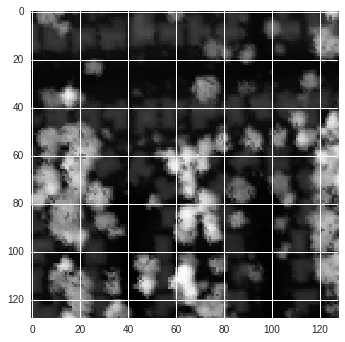

In [4]:




# lon = [meta['lon'][250000]] #these are good becuase of clear local features
# lat = [meta['lat'][250000]]


lon = [meta['lon'][12000]]
lat = [meta['lat'][12000]]

print "house lat lon", lat, lon
xx, yy = pyproj.transform(wgs84, UTM26N, lon, lat)
print xx, yy
housex=xx[0]
housey=yy[0]
display(get_heightmap_around(housex,housey, window_width_pixels = image_width))

n=10000




In [9]:
y_average = np.mean(y_gaussian)
    
batch_costs = []

import tflearn
tf.reset_default_graph()
image_data = tf.placeholder(tf.float32, [None, image_width, image_width, 1], name = 'image_data_placeholder')
labels = tf.placeholder(tf.float32, [None, 2], name = 'labels_data_placeholder')
regression_y_ph = tf.placeholder(tf.float32, [None, 35], name = 'regr_data_placeholder')


learning_rate_input = tf.placeholder(tf.float32)

print image_data.get_shape(), "<- image input"
weights = []

network = tflearn.conv_2d(image_data, 32, 7, strides=1, activation='relu')
weights.append(network.W)
bottom_conv = network
# network = tflearn.layers.dropout(network, .7)

# network = tflearn.layers.normalization.batch_normalization(network)

# network = tflearn.layers.dropout(network, .7)
network = tflearn.layers.conv.max_pool_2d (network, 2)

# network = tflearn.layers.dropout(network, .7)
network = tflearn.conv_2d(network, 64, 7, strides=1, activation='relu')
weights.append(network.W)

# network = tflearn.layers.normalization.batch_normalization(network)

# network = tflearn.layers.dropout(network, .7)
network = tflearn.conv_2d(network, 64, 7, strides=1, activation='relu')
weights.append(network.W)

# network = tflearn.layers.normalization.batch_normalization(network)

# network = tflearn.layers.dropout(network, .7)
network = tflearn.layers.conv.max_pool_2d (network, 2)

network = tflearn.conv_2d(network, 64, 7, strides=1, activation='relu')
weights.append(network.W)

# network = tflearn.layers.normalization.batch_normalization(network)

# network = tflearn.layers.dropout(network, .7)

network = tflearn.conv_2d(network, 64, 7, strides=1, activation='relu')
weights.append(network.W)

# network = tflearn.layers.normalization.batch_normalization(network)

# network = tflearn.layers.dropout(network, .7)

network = tflearn.layers.conv.max_pool_2d (network, 2)


print (network.get_shape())

# network = tflearn.layers.conv.max_pool_2d (network, 3, )
# network = tflearn.layers.dropout(network, .5)
# network = tflearn.layers.fully_connected(network, 100, activation='relu')
# network = tflearn.layers.normalization.batch_normalization(network)

fully_connected_hidden_layer = network
# network = tflearn.layers.dropout(network, .7)

network = tflearn.layers.fully_connected(network, 35, activation='sigmoid')
weights.append(network.W)


for i in range(len(weights)):
    weights[i] = tf.reduce_mean(tf.square(weights[i]))


L2_reg = tf.reduce_mean(weights)
L2_loss = tf.reduce_mean(tf.square(network - regression_y_ph))


loss = L2_loss #+ .01*L2_reg
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_input).minimize(loss)
saver = tf.train.Saver()

init = tf.initialize_all_variables()
# Launch the graph
sess = tf.Session()
sess.run(init)

# y_average = np.mean(y_gaussian)
batch_costs = []
val_costs = []
naive_model_costs = []


(?, 128, 128, 1) <- image input
(?, 16, 16, 64)


In [19]:
pylab.rcParams['figure.figsize'] = (5.0, 5.0)


In [67]:
print np.max(hcad)

image_data_data, extra_features_data, batch_y_regression, batch_y_categorical\
        = get_batch(batch_size=60, randomize = True, start_index = 0, end_index = 100000)  
    
bc_w = sess.run([bottom_conv], feed_dict=
                         {image_data: image_data_data,
                          labels : batch_y_categorical,
                          regression_y_ph : batch_y_regression,
                          learning_rate_input : 1
                         })

print bc_w

1.0
[array([[[[  9.02199364e+00,   0.00000000e+00,   0.00000000e+00, ...,
            9.15922928e+00,   1.73680019e+01,   1.73944244e+01],
         [  1.18373547e+01,   0.00000000e+00,   0.00000000e+00, ...,
            1.22454033e+01,   2.02782650e+01,   2.02517452e+01],
         [  1.61995888e+01,   0.00000000e+00,   0.00000000e+00, ...,
            1.35283756e+01,   2.44728546e+01,   2.43330116e+01],
         ..., 
         [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            5.36560202e+00,   6.47524548e+00,   6.50126982e+00],
         [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            5.21302700e+00,   5.88795757e+00,   5.91033649e+00],
         [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            5.15068531e+00,   5.62011623e+00,   5.63694382e+00]],

        [[  1.11779346e+01,   0.00000000e+00,   0.00000000e+00, ...,
            4.47654772e+00,   1.96229401e+01,   1.96139259e+01],
         [  1.44416332e+01,   0.00000000

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:40: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [ ]:
from ipywidgets import FloatProgress
from IPython.display import display

step = 1
batches_per_display = 500

f = FloatProgress(min=0, max=batches_per_display, readout = True)
display(f)
  

def show_image(image_mat, index):
    print np.min(image_mat[index,:,:,0]),np.max(image_mat[index,:,:,0])

    plt.imshow(image_mat[index,:,:,0])
    plt.show()

while step < batches_per_display * 5000:
    batch_cost = 0
    learning_rate = .00001*.99995**step

    for _ in range(10):
        image_data_data, extra_features_data, batch_y_regression, batch_y_categorical\
                = get_batch(batch_size=40, randomize = True, start_index = 0, end_index = 500000)  

        _, batch_cost, pred, fc_out = sess.run([optimizer, loss, network, fully_connected_hidden_layer], feed_dict=
                                 {image_data: image_data_data,
                                  labels : batch_y_categorical,
                                  regression_y_ph : batch_y_regression,
                                  learning_rate_input : learning_rate
                                 })
#     print np.min(image_data_data),  np.max(image_data_data)
#     print np.min(batch_y_regression),  np.max(batch_y_regression)

#     plt.scatter(pred[0], batch_y_regression[0])
#     plt.show()
#     plt.hist(batch_y_regression)
#     plt.show()
#     plt.hist(fc_out.flatten(), bins = 50)
#     plt.show()
#     print pred[0]
#     print fc_out[0]
    
    vimage_data_data, _, vbatch_y_regression, vbatch_y_categorical\
            = get_batch(batch_size=10, randomize = True, start_index = 0, end_index = 500000, val = True)  
    val_cost = sess.run([loss], feed_dict=
                             {image_data: vimage_data_data,
                              labels : vbatch_y_categorical,
                              regression_y_ph : vbatch_y_regression,
                             })[0]
#     batch_cost = sess.run([loss], feed_dict=
#                          {image_data: image_data_data,
#                           labels : batch_y_categorical,
#                           learning_rate_input : .0001
#                          })[0]
#     naive_loss = np.mean(np.square(np.array([y_average]*len(batch_y_regression)) - batch_y_regression))
#     naive_model_costs.append(naive_loss)
    batch_costs.append(batch_cost)
    val_costs.append(val_cost)
    f.value = step % batches_per_display
    if  step % batches_per_display == 0:
        saver.save(sess, "128x128_regression_model_no_L2_reg_10_31.ckpt", global_step = step)
        pylab.rcParams['figure.figsize'] = (2,2)
        print pred.shape
        print batch_y_regression.shape
#         for i in range(pred.shape[1]):
#             plt.hist(batch_y_regression[:,i])
#             plt.hist(pred[:,i])
#             plt.show()
#             plt.scatter(pred[:,i],batch_y_regression[:,i])
#             plt.show()
        moving_window_size = 50
        plt.plot(batch_costs[:])
        plt.show()
        plt.plot(np.convolve(batch_costs[:], 
                            np.ones(moving_window_size)/moving_window_size)[moving_window_size:-moving_window_size])
        
        plt.plot(np.convolve(val_costs[:], 
                            np.ones(moving_window_size)/moving_window_size)[moving_window_size:-moving_window_size])
#         plt.plot(np.convolve(naive_model_costs, 
#                             np.ones(moving_window_size)/moving_window_size)[moving_window_size:-moving_window_size])
        plt.show()

        print batch_costs[-1]
       

    step += 1
print "Optimization Finished!"

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:304: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [4]:
print step

17273


In [40]:
hcad_for_labels = load_data("/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_point.hd", 
              normalize_columns=True)
hcad_labels = list(hcad_for_labels.columns)
del hcad_for_labels

loading...
Opening /home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_point.hd in read-only mode


accrued_depr_pct


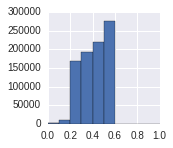

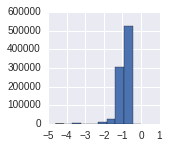

active_area


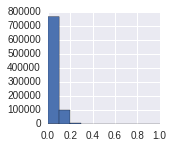

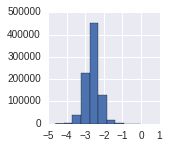

assessed_val


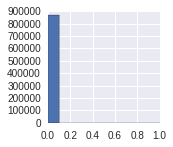

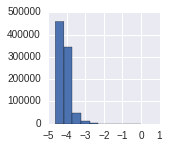

base_area


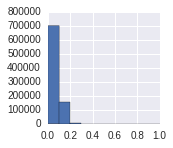

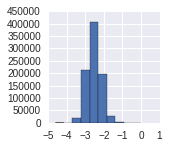

bld_ar


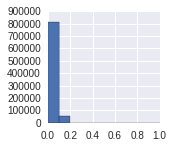

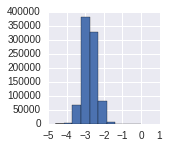

bld_val


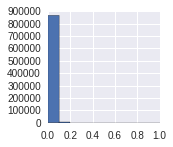

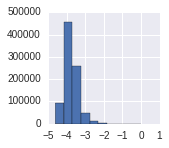

bldg_adj


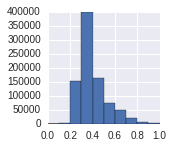

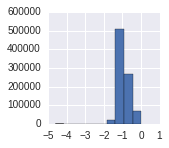

cama_replacement_cost


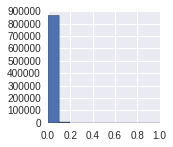

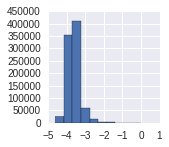

dpr_val


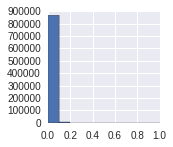

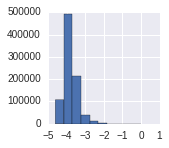

effective_area


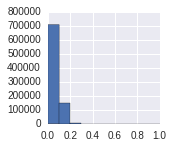

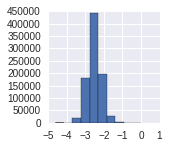

gross_area


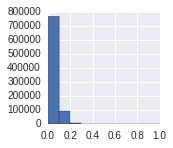

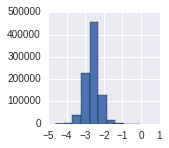

heated_area


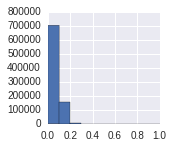

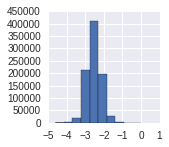

improved_sqft


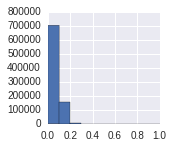

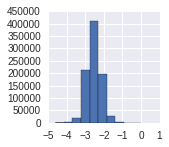

index


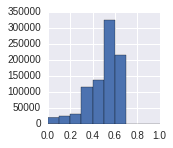

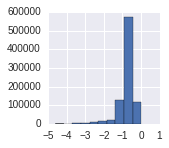

land_ar


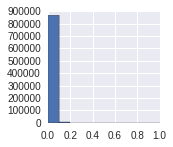

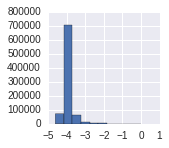

land_val


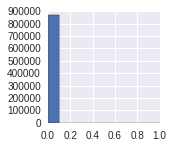

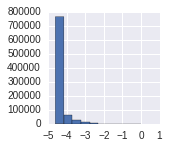

new_construction_val


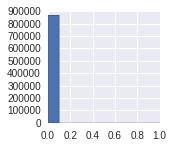

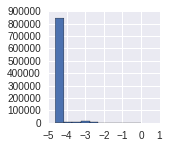

perimeter


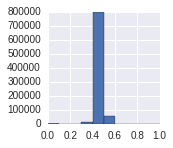

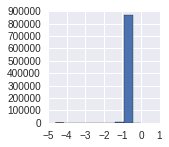

pointx


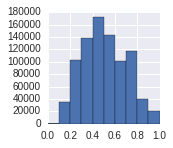

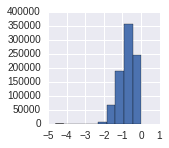

pointy


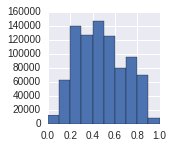

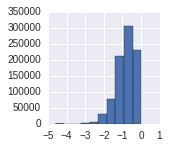

prior_bld_val


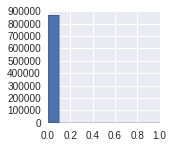

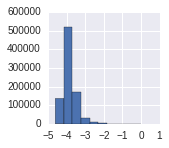

prior_land_val


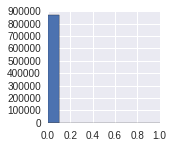

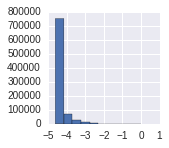

prior_tot_appr_val


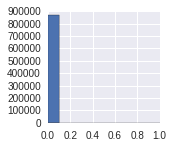

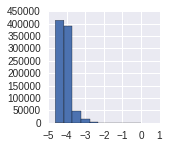

prior_tot_mkt_val


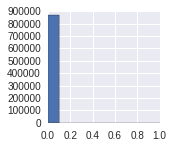

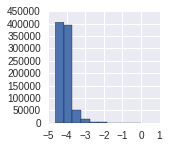

prior_x_features_val


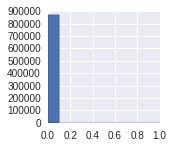

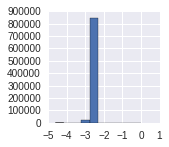

quality


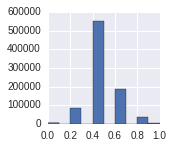

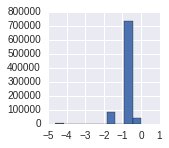

rcnld


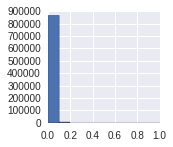

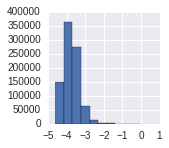

size_index


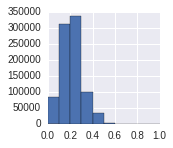

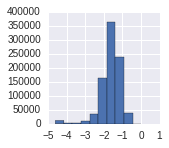

tot_appr_val


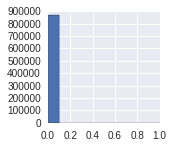

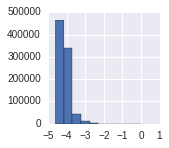

tot_mkt_val


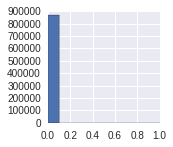

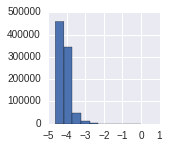

tot_rcn_val


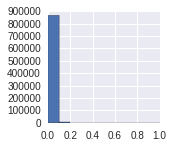

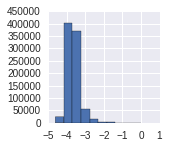

x_features_val


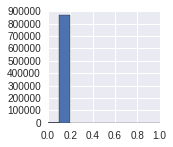

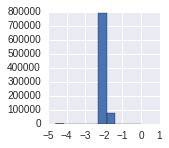

year_built


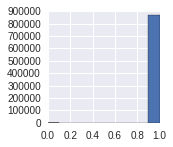

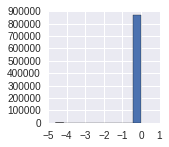

year_remodeled


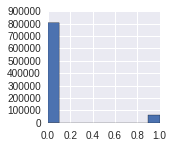

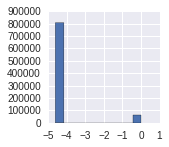

yr_impr


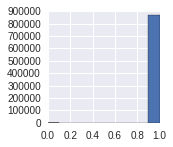

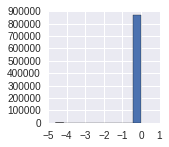

In [45]:

for i in range(hcad.shape[1]):
    print hcad_labels[i]
    plt.hist(hcad[:,i])
    plt.show()
    plt.hist(np.log(hcad[:,i]+.01))
    plt.show()

In [4]:
saver.save(sess, "128x128_regression_model_no_L2_reg_some_generalization.ckpt", global_step = step)

'128x128_regression_model_no_L2_reg_some_generalization.ckpt-230482'

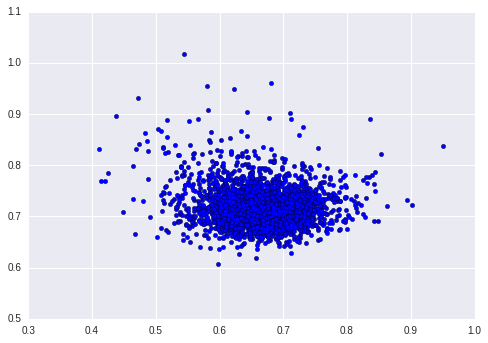

In [7]:
plt.scatter(batch_costs, val_costs)

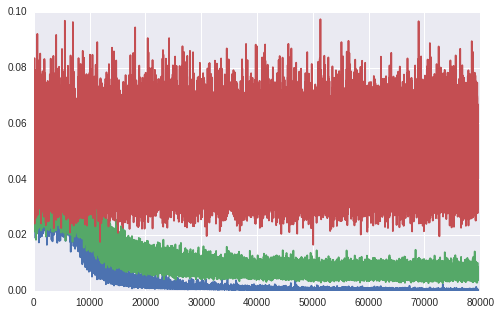

In [56]:
pylab.rcParams['figure.figsize'] = (8.0, 5.0)

plt.plot(batch_costs)
plt.plot(val_costs)
plt.plot(naive_model_costs)
plt.show()

(4, 128, 128, 1)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:304: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


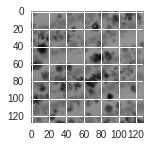

('filter', 0)


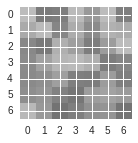

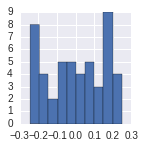

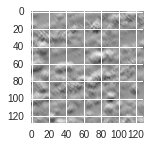

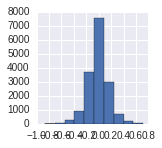

('filter', 1)


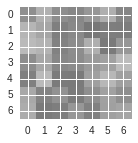

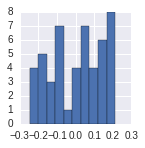

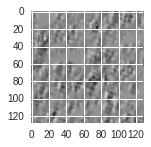

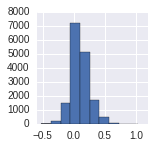

('filter', 2)


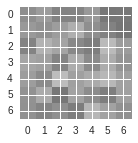

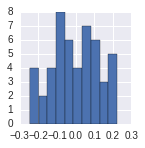

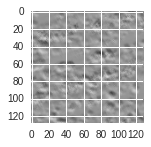

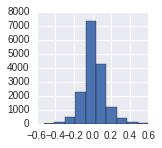

('filter', 3)


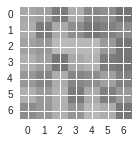

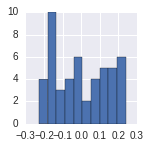

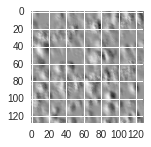

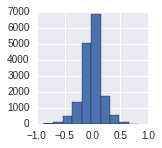

('filter', 4)


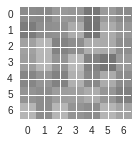

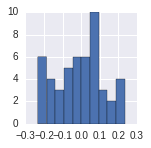

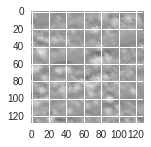

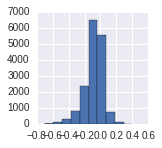

('filter', 5)


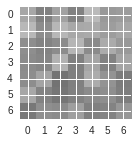

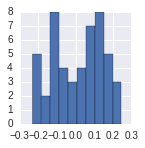

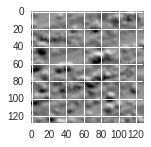

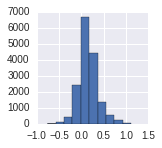

('filter', 6)


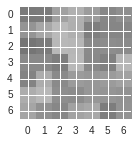

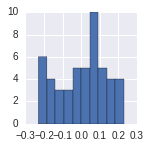

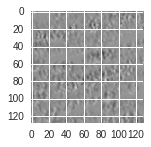

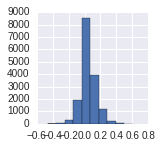

('filter', 7)


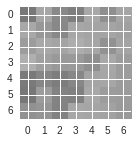

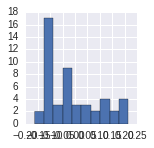

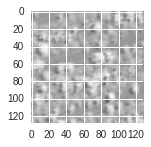

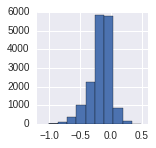

('filter', 8)


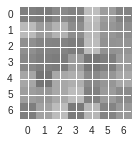

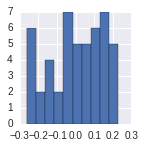

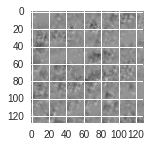

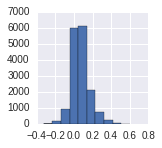

('filter', 9)


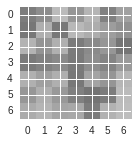

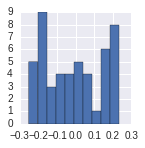

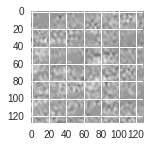

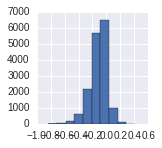

('filter', 10)


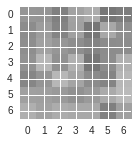

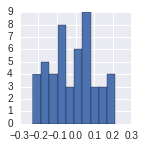

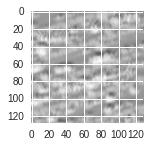

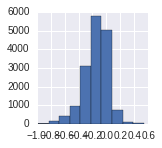

('filter', 11)


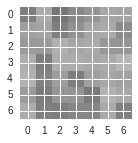

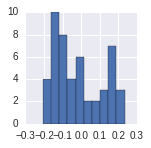

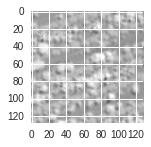

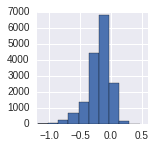

('filter', 12)


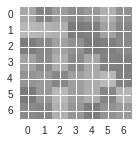

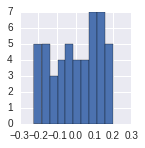

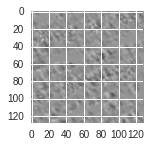

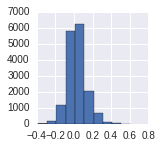

('filter', 13)


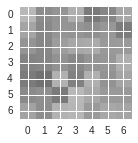

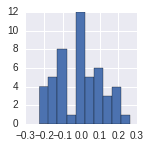

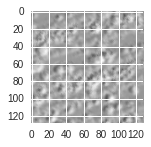

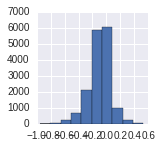

('filter', 14)


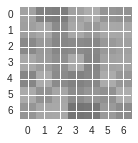

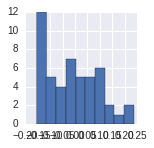

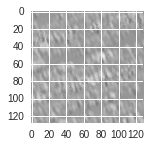

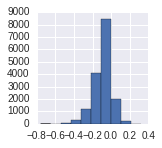

('filter', 15)


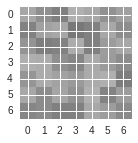

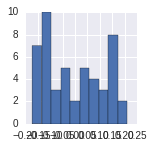

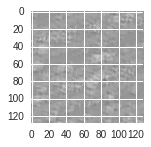

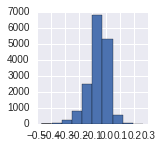

('filter', 16)


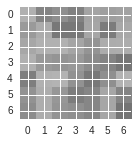

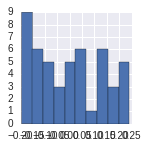

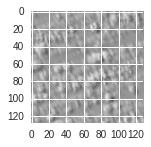

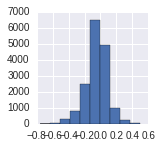

('filter', 17)


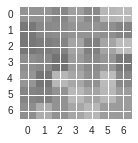

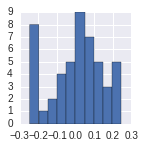

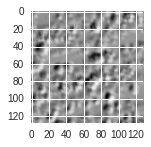

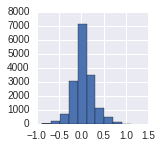

('filter', 18)


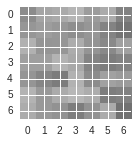

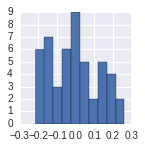

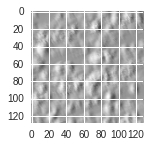

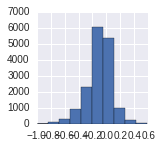

('filter', 19)


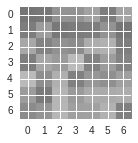

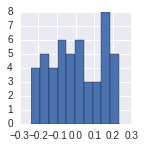

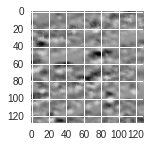

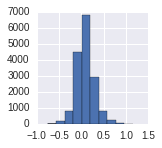

('filter', 20)


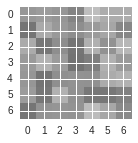

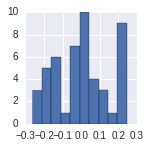

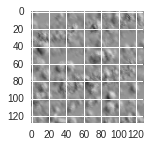

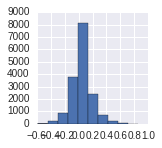

('filter', 21)


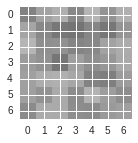

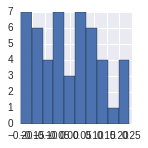

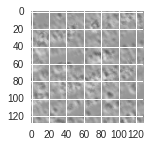

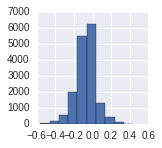

('filter', 22)


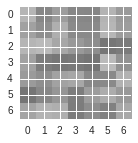

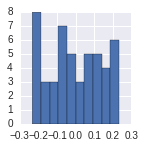

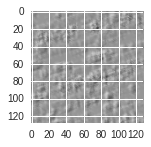

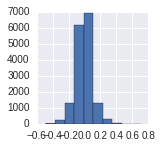

('filter', 23)


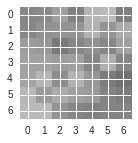

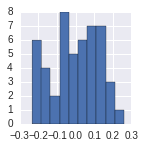

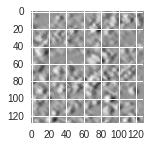

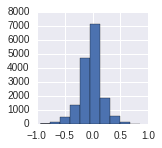

('filter', 24)


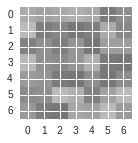

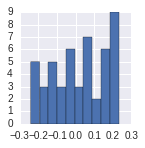

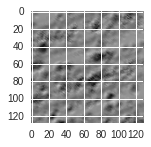

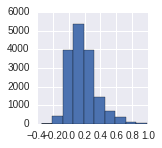

('filter', 25)


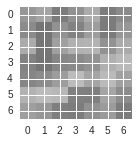

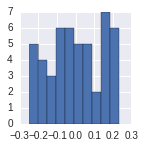

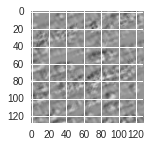

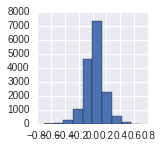

('filter', 26)


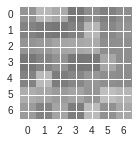

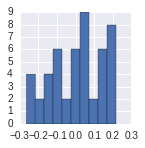

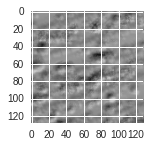

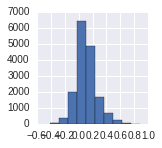

('filter', 27)


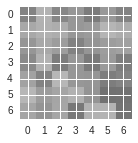

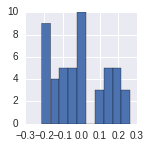

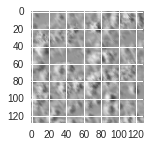

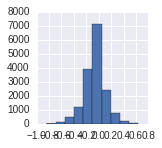

('filter', 28)


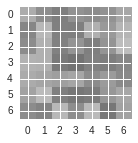

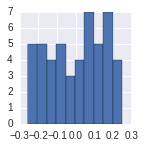

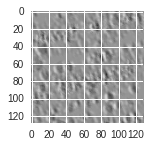

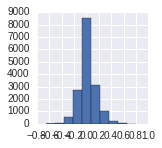

('filter', 29)


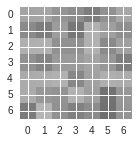

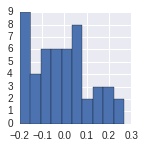

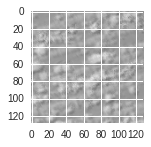

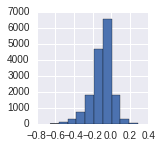

('filter', 30)


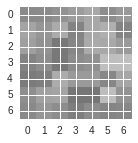

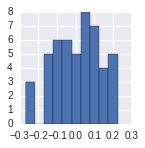

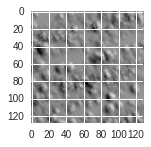

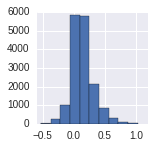

('filter', 31)


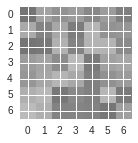

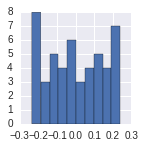

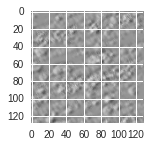

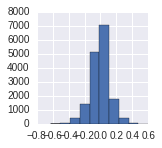

In [17]:
pylab.rcParams['figure.figsize'] = (2.0, 2.0)


from scipy import signal
bottom_conv_weights = sess.run(bottom_conv.W)

image_data_data, extra_features_data, batch_y_regression, batch_y_categorical\
            = get_batch(batch_size=4, randomize = True, start_index = 0, end_index = 10000) 

print ( image_data_data.shape)
plt.imshow(image_data_data[0,:,:, 0], vmin = -1, vmax = 1)
plt.show()
for i in range(bottom_conv_weights.shape[-1]):
#     fig, axs = plt.subplots(1,2)

    print ("filter", i)
    plt.imshow(bottom_conv_weights[:,:,0,i], vmin = -1, vmax = 1, interpolation = "nearest")
    plt.show()

    filt = bottom_conv_weights[:,:,0,i]
    plt.hist(filt.flatten())
    plt.show()
    grad = signal.convolve2d(image_data_data[0,:,:,0], filt, boundary='symm', mode='same')
    plt.imshow(grad, vmin = -1, vmax = 1)
    plt.show()
    plt.hist(grad.flatten())
    plt.show()


230482
0.0011926


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:304: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


0.00108559
0.00131808
0.00135111
0.00147041
0.00128399
0.00120614
0.00132154
0.00117085
0.00155213
0.00149295
0.00117397
0.00115211
0.0012604
0.00103687
0.00133516
0.00184594
0.00154736
0.00124452
0.00115598
0.00130988


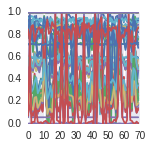

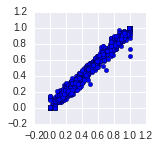

In [11]:
print step
average_costs = []
for _ in range(20):
    image_data_data, extra_features_data, batch_y_regression, batch_y_categorical\
            = get_batch(batch_size=70, randomize = True, end_index = 100000, val = False)  
#     plt.imshow(image_data_data[0,:,:, 0], vmin = -1, vmax = 1)
#     plt.show()

    batch_cost, preds = sess.run([loss, network], feed_dict=
                             {image_data: image_data_data,
                              labels : batch_y_categorical,
                              regression_y_ph : batch_y_regression,
                              learning_rate_input : .0001
                             })
    print batch_cost
    average_costs.append(batch_cost)
    
print np.mean(average_costs)
plt.plot(batch_y_regression)
plt.plot(preds)
plt.show()
plt.scatter(batch_y_regression, preds)

plt.show()

In [33]:
print len(meta)

870476


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:256: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


mean MSE: 0.0284962


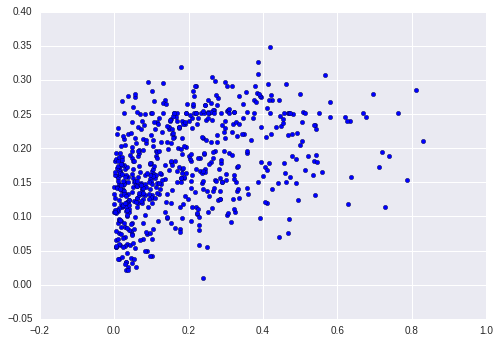

In [27]:
image_data_data, extra_features_data, batch_y = get_batch(batch_size=600, random = True, val = False)
y_list = batch_y.reshape([-1])

print "mean MSE:", np.mean(np.square(np.array([np.mean(y_list)]*len(y_list)) - y_list))
prediction = sess.run(y_pred, feed_dict={image_data: image_data_data,
                                   extra_features: extra_features_data,
                                   y: batch_y})
plt.scatter(y_list, prediction)

In [ ]:
y_predicted = []
for i in range(0,len(wind_data), batch_size):
    image_data_data, extra_features_data, batch_y = get_batch(batch_size=batch_size, random = False, start_index = i)
    y_predicted.extend([x[0] for x in sess.run(pred, feed_dict={image_data: image_data_data,
                                   extra_features: extra_features_data,
                                   y: batch_y,
                                   keep_prob: 1.0})])


    

In [ ]:
for _ in range(10000):
    X, extra_features_data, Y = get_batch(batch_size= 15000, random = False)
    model.fit(X, Y, n_epoch=1000, 
              show_metric=True, run_id="dense_model", batch_size=None, shuffle=None, snapshot_epoch=False)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:252: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
